In [51]:
import numpy as np
import sklearn as sk
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.cluster import KMeans
from sklearn import metrics
import math
from yellowbrick.cluster import SilhouetteVisualizer
from pyclustering.cluster.kmedians import kmedians
from matplotlib import cm

In [113]:
n = 1000

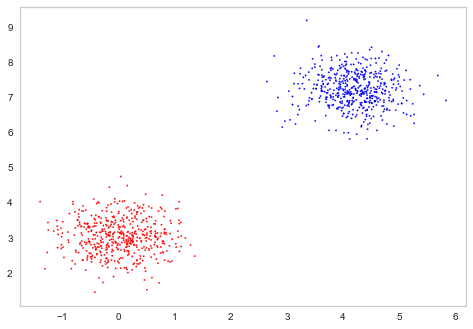

In [114]:
blobs, blob_labels = sk.datasets.make_blobs(n_samples=n, n_features=2, center_box=(0, 10.0), centers=2, cluster_std=0.5, random_state=1)
blobs = blobs.round(3)
plt.scatter(blobs[:, 0], blobs[:, 1], c=blob_labels, cmap="bwr", s=2)
plt.grid(which='major');

In [115]:
k = 2
d = 2 #0.00005 #0.000005 #0.0000005
eps = 0.1
X = blobs
n_initial = len(X) # the size of the current point set, a.k.a. n is all of the initial points

In [116]:
def visualize_splitting(Z, c_centers, lines, X, initial_bbox, title="Sub-Cell Construction"):
    plt.figure(figsize=(8, 6))

    # Plot the initial bounding box
    bbox = np.array(initial_bbox)
    plt.plot(bbox[:, 0], bbox[:, 1], color='green', linestyle='-', linewidth=1) #label='Initial Bounding Box'

    # Plot the original points
    plt.scatter(X[:, 0], X[:, 1], color='blue', marker='.', label='Original Points')

    # Plot cell centers
    centers = np.array(c_centers)
    plt.scatter(centers[:, 0], centers[:, 1], color='red', marker='x', label='Cell Centers', s=45)

    # Plot the splitting lines
    for line in lines:
        for rect_coords in line:
            rect = patches.Rectangle(
                (rect_coords[0][0], rect_coords[1][0]),  # Bottom-left and top-right corner
                rect_coords[0][1] - rect_coords[0][0],   # Width
                rect_coords[1][1] - rect_coords[1][0],   # Height
                edgecolor='green', facecolor='none')
            plt.gca().add_patch(rect)

    plt.title(title)
    plt.axis("off")
    plt.legend(loc='upper left', bbox_to_anchor=(0.03, 1.08), frameon=True, framealpha=1, edgecolor='black')
    plt.grid(False)
    plt.show()

In [123]:
def recursive_split(X, y, cell, k, d, eps, opt, n_initial, delta, nr_of_cells, cs, i, lines, Z, c_centers, labels):
    x1, x2, y1, y2 = cell
    points_in_cell = X[(X[:, 0] >= x1) & (X[:, 0] <= x2) & (X[:, 1] >= y1) & (X[:, 1] <= y2)]
    labels_in_cell = y[(X[:, 0] >= x1) & (X[:, 0] <= x2) & (X[:, 1] >= y1) & (X[:, 1] <= y2)]

    threshold = ((delta)*opt) / pow(2, i)
    print("Threshold value:", round(threshold, 5), "Points in cell:", len(points_in_cell))
    if len(points_in_cell) < threshold:
        # If there are less than the threshold number of points, it's a light cell
        # First time this is checked, it checks the grid g**i if it is light (step #3)
        # Afterwards when it recurs it does step #3.4, marks c as a light cell and adds it to Z
        # Also when it recurs it does step #3.5 here (delete c from Y) as the light cell c will no longer be recured
        
        if len(points_in_cell) >= 1: 
            #print("\033[1m Points in light cell:\n", points_in_cell, "\033[0;0m")
            # If c is not empty (this already checks step #4)
            Z.append(points_in_cell)
            # Save the center coordinates for step #4.1
            c_centers.append(((x1 + x2) / 2, (y1 + y2) / 2))
            labels.append(labels_in_cell)
    else: 
        #print("Current number of cells: " + str(nr_of_cells))
        # Cell counter, each time a cell gets split into 4 subcells the total increases by 3
        nr_of_cells = nr_of_cells + 3

        # The would-be number of cells if the below code executes
        # Does not allow to create more subcells than cs
        if i>=0 and len(points_in_cell)!=0:# and i >= np.log(delta * opt)+1: # and nr_of_cells <= cs:
        
            # Step #3.1 if c is heavy then: Split the cell
            # First time this executes - only if g**i is heavy and splits it into 4 sub-cells c1, c2, c3, c4 (step #3)
            # Afterwards the level of each cell goes to g**i-1, with side length 2**i-1 with each recursion
            i = i - 1
            mid_x = (x1 + x2) / 2
            mid_y = (y1 + y2) / 2
            
            lines.append([
                ((x1, mid_x), (y1, mid_y)),  # Top-left
                ((mid_x, x2), (y1, mid_y)),  # Top-right
                ((x1, mid_x), (mid_y, y2)),  # Bottom-left
                ((mid_x, x2), (mid_y, y2))])  # Bottom-right
            
            cells = [
                (x1, mid_x, y1, mid_y),  # Top-left
                (mid_x, x2, y1, mid_y),  # Top-right
                (x1, mid_x, mid_y, y2),  # Bottom-left
                (mid_x, x2, mid_y, y2)   # Bottom-right
            ]
            # Step #3.2 and #3.3 as it implicitly adds c1, c2, c3, c4 to Y with each recursion below
            for sub_cell in cells:
                recursive_split(points_in_cell, labels_in_cell, sub_cell, k, d, eps, opt, n_initial, delta, nr_of_cells, cs, i, lines,
                                Z, c_centers, labels)
    return Z, c_centers, lines, labels

In [118]:
def coreset(Z, rep_c, delta, cs, eps, labels):
    # rep_c = c_centers = representative center point of a cell
    # n_c = number of  points in each cell
    n_c = [len(c) for c in Z]
    # S = pairs respective center coordinates with number of points in each cell
    S = []
    
    for index in range(0, len(rep_c)):
        unique_labels, counts = np.unique(labels[index], return_counts=True)
        majority_label = unique_labels[np.argmax(counts)]
        S.append([rep_c[index], n_c[index], majority_label])
    #print(rep_c, n_c)
    if len(S) > cs*(1+eps) or len(S) == 0:
        return None # failure indication
    else:
        return S

In [119]:
def coreset_construction(X, y, k, d, eps, n_initial):
    
    if X.size > 0: 
        print("The array is non-empty, proceeding with coreset construction algorithm")
        
        # Step #1: Define the boundaries of the coordinate plane, at the start let Y be the only cell in grid g^(log(D))
        x_min, x_max, y_min, y_max = min(X[:, 0]), max(X[:, 0]), min(X[:, 1]), max(X[:, 1])
        Y = x_min, x_max, y_min, y_max
        
        # Calculate delta
        #delta below 6 fails to construct coreset
        delta = ( 1 / ( (4*k*np.sqrt(d)) * (np.log(n_initial)+1) ) )
        if delta < 1: delta = 6
        #delta = ( 1 / ( (4*k*np.sqrt(d)) * (np.log(n_initial)+1) ) ) * pow( ( eps / (14*np.sqrt(d)) ), d)
        print("delta =", round(delta, 4))
        # Calculate coreset size
        cs = math.ceil(2/delta + (np.log(n_initial) + 2) * k * pow(2, d))
        print("cs =", cs)
        DELTA = 6 # take DELTA as an arbitrary constant, lets say 5
        # Opt = number of guesses for opt approx., round up: (delta+1) * log_base(1 + eps)(DELTA) * (sqrt(2))
        Opt =  math.ceil( (delta+1) * (np.log(np.sqrt(DELTA))/np.log(1 + eps)) * np.sqrt(2) )
        print("Number of guesses for opt approximation =", Opt)

        for j in range(0, Opt):
            print("\nIteration j = " + str(j) + ", with approximation Opt = (1+eps)^j = " + str(pow((1+eps), j)) + "\n")
            
            # Cell counter
            nr_of_cells = 1
            # i-th iteration tracking for recursive alg
            i = DELTA
            # Lines defining sub-cell boundries
            lines = []
            # Step #0: arr to store light cells c
            Z = []
            # Cell centers
            c_centers = []
            # Label for each coreset point
            labels = []

            # Start the recursive splitting, here Opt = (1+eps)^j
            Z, c_centers, lines, labels = recursive_split(X, y, Y, k, d, eps, pow((1+eps), j), n_initial,
                                                  delta, nr_of_cells, cs, i, lines, Z, c_centers, labels)
            # Start the coreset calculation
            S = coreset(Z, c_centers, delta, cs, eps, labels)
                        
            if S is not None:
                print("\n Coreset constructed: \n", S, ", of size:", len(S))
                
                initial_bbox = [[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max], [x_min, y_min]]
                visualize_splitting(Z, c_centers, lines, X, initial_bbox)
                
                return S
        return "Coreset could not be constructed"
    else:
        return "The array is empty."

The array is non-empty, proceeding with coreset construction algorithm
delta = 6
cs = 72
Number of guesses for opt approximation = 94

Iteration j = 0, with approximation Opt = (1+eps)^j = 1.0

Threshold value: 0.09375 Points in cell: 1000
Threshold value: 0.1875 Points in cell: 500
Threshold value: 0.375 Points in cell: 287
Threshold value: 0.75 Points in cell: 8
Threshold value: 1.5 Points in cell: 0
Threshold value: 1.5 Points in cell: 0
Threshold value: 1.5 Points in cell: 1
Threshold value: 1.5 Points in cell: 7
Threshold value: 3.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 2
Threshold value: 3.0 Points in cell: 3
Threshold value: 6.0 Points in cell: 0
Threshold value: 6.0 Points in cell: 0
Threshold value: 6.0 Points in cell: 2
Threshold value: 6.0 Points in cell: 1
Threshold value: 0.75 Points in cell: 37
Threshold value: 1.5 Points in cell: 4
Threshold value: 3.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 0
Thresho

Threshold value: 0.825 Points in cell: 37
Threshold value: 1.65 Points in cell: 4
Threshold value: 3.3 Points in cell: 1
Threshold value: 3.3 Points in cell: 0
Threshold value: 3.3 Points in cell: 2
Threshold value: 3.3 Points in cell: 1
Threshold value: 1.65 Points in cell: 0
Threshold value: 1.65 Points in cell: 15
Threshold value: 3.3 Points in cell: 0
Threshold value: 3.3 Points in cell: 2
Threshold value: 3.3 Points in cell: 5
Threshold value: 6.6 Points in cell: 0
Threshold value: 6.6 Points in cell: 1
Threshold value: 6.6 Points in cell: 2
Threshold value: 6.6 Points in cell: 2
Threshold value: 3.3 Points in cell: 8
Threshold value: 6.6 Points in cell: 2
Threshold value: 6.6 Points in cell: 0
Threshold value: 6.6 Points in cell: 4
Threshold value: 6.6 Points in cell: 2
Threshold value: 1.65 Points in cell: 18
Threshold value: 3.3 Points in cell: 5
Threshold value: 6.6 Points in cell: 0
Threshold value: 6.6 Points in cell: 1
Threshold value: 6.6 Points in cell: 1
Threshold value:

Threshold value: 7.26 Points in cell: 2
Threshold value: 7.26 Points in cell: 1
Threshold value: 7.26 Points in cell: 2
Threshold value: 7.26 Points in cell: 3
Threshold value: 1.815 Points in cell: 6
Threshold value: 3.63 Points in cell: 1
Threshold value: 3.63 Points in cell: 0
Threshold value: 3.63 Points in cell: 3
Threshold value: 3.63 Points in cell: 2
Threshold value: 1.815 Points in cell: 38
Threshold value: 3.63 Points in cell: 12
Threshold value: 7.26 Points in cell: 3
Threshold value: 7.26 Points in cell: 2
Threshold value: 7.26 Points in cell: 5
Threshold value: 7.26 Points in cell: 2
Threshold value: 3.63 Points in cell: 13
Threshold value: 7.26 Points in cell: 4
Threshold value: 7.26 Points in cell: 1
Threshold value: 7.26 Points in cell: 5
Threshold value: 7.26 Points in cell: 3
Threshold value: 3.63 Points in cell: 7
Threshold value: 7.26 Points in cell: 3
Threshold value: 7.26 Points in cell: 2
Threshold value: 7.26 Points in cell: 1
Threshold value: 7.26 Points in cel

Threshold value: 7.986 Points in cell: 5
Threshold value: 7.986 Points in cell: 2
Threshold value: 3.993 Points in cell: 15
Threshold value: 7.986 Points in cell: 4
Threshold value: 7.986 Points in cell: 4
Threshold value: 7.986 Points in cell: 2
Threshold value: 7.986 Points in cell: 5
Threshold value: 0.49913 Points in cell: 183
Threshold value: 0.99825 Points in cell: 12
Threshold value: 1.9965 Points in cell: 0
Threshold value: 1.9965 Points in cell: 0
Threshold value: 1.9965 Points in cell: 9
Threshold value: 3.993 Points in cell: 3
Threshold value: 3.993 Points in cell: 1
Threshold value: 3.993 Points in cell: 0
Threshold value: 3.993 Points in cell: 5
Threshold value: 7.986 Points in cell: 1
Threshold value: 7.986 Points in cell: 1
Threshold value: 7.986 Points in cell: 1
Threshold value: 7.986 Points in cell: 2
Threshold value: 1.9965 Points in cell: 3
Threshold value: 3.993 Points in cell: 0
Threshold value: 3.993 Points in cell: 0
Threshold value: 3.993 Points in cell: 1
Thre

Threshold value: 9.66306 Points in cell: 1
Threshold value: 9.66306 Points in cell: 3
Threshold value: 4.83153 Points in cell: 1
Threshold value: 4.83153 Points in cell: 3
Threshold value: 4.83153 Points in cell: 9
Threshold value: 9.66306 Points in cell: 2
Threshold value: 9.66306 Points in cell: 4
Threshold value: 9.66306 Points in cell: 0
Threshold value: 9.66306 Points in cell: 3
Threshold value: 1.20788 Points in cell: 53
Threshold value: 2.41577 Points in cell: 6
Threshold value: 4.83153 Points in cell: 1
Threshold value: 4.83153 Points in cell: 1
Threshold value: 4.83153 Points in cell: 0
Threshold value: 4.83153 Points in cell: 4
Threshold value: 2.41577 Points in cell: 20
Threshold value: 4.83153 Points in cell: 2
Threshold value: 4.83153 Points in cell: 7
Threshold value: 9.66306 Points in cell: 0
Threshold value: 9.66306 Points in cell: 3
Threshold value: 9.66306 Points in cell: 1
Threshold value: 9.66306 Points in cell: 3
Threshold value: 4.83153 Points in cell: 1
Threshold

Threshold value: 10.62937 Points in cell: 3
Threshold value: 10.62937 Points in cell: 3
Threshold value: 10.62937 Points in cell: 2
Threshold value: 2.65734 Points in cell: 5
Threshold value: 5.31468 Points in cell: 1
Threshold value: 5.31468 Points in cell: 3
Threshold value: 5.31468 Points in cell: 0
Threshold value: 5.31468 Points in cell: 1
Threshold value: 2.65734 Points in cell: 18
Threshold value: 5.31468 Points in cell: 5
Threshold value: 5.31468 Points in cell: 7
Threshold value: 10.62937 Points in cell: 2
Threshold value: 10.62937 Points in cell: 2
Threshold value: 10.62937 Points in cell: 0
Threshold value: 10.62937 Points in cell: 3
Threshold value: 5.31468 Points in cell: 4
Threshold value: 5.31468 Points in cell: 2
Threshold value: 1.32867 Points in cell: 0
Threshold value: 1.32867 Points in cell: 3
Threshold value: 2.65734 Points in cell: 2
Threshold value: 2.65734 Points in cell: 0
Threshold value: 2.65734 Points in cell: 1
Threshold value: 2.65734 Points in cell: 0
Thr

Threshold value: 1.60769 Points in cell: 0
Threshold value: 1.60769 Points in cell: 0
Threshold value: 1.60769 Points in cell: 0
Threshold value: 0.40192 Points in cell: 0
Threshold value: 0.40192 Points in cell: 0
Threshold value: 0.40192 Points in cell: 500
Threshold value: 0.80385 Points in cell: 89
Threshold value: 1.60769 Points in cell: 1
Threshold value: 1.60769 Points in cell: 4
Threshold value: 3.21538 Points in cell: 0
Threshold value: 3.21538 Points in cell: 0
Threshold value: 3.21538 Points in cell: 1
Threshold value: 3.21538 Points in cell: 3
Threshold value: 1.60769 Points in cell: 7
Threshold value: 3.21538 Points in cell: 0
Threshold value: 3.21538 Points in cell: 3
Threshold value: 3.21538 Points in cell: 0
Threshold value: 3.21538 Points in cell: 4
Threshold value: 6.43077 Points in cell: 1
Threshold value: 6.43077 Points in cell: 1
Threshold value: 6.43077 Points in cell: 0
Threshold value: 6.43077 Points in cell: 2
Threshold value: 1.60769 Points in cell: 77
Thresho

Threshold value: 15.56245 Points in cell: 5
Threshold value: 15.56245 Points in cell: 1
Threshold value: 15.56245 Points in cell: 3
Threshold value: 7.78123 Points in cell: 3
Threshold value: 7.78123 Points in cell: 3
Threshold value: 3.89061 Points in cell: 26
Threshold value: 7.78123 Points in cell: 6
Threshold value: 7.78123 Points in cell: 7
Threshold value: 7.78123 Points in cell: 4
Threshold value: 7.78123 Points in cell: 9
Threshold value: 15.56245 Points in cell: 1
Threshold value: 15.56245 Points in cell: 4
Threshold value: 15.56245 Points in cell: 3
Threshold value: 15.56245 Points in cell: 1
Threshold value: 3.89061 Points in cell: 8
Threshold value: 7.78123 Points in cell: 4
Threshold value: 7.78123 Points in cell: 3
Threshold value: 7.78123 Points in cell: 0
Threshold value: 7.78123 Points in cell: 1
Threshold value: 3.89061 Points in cell: 8
Threshold value: 7.78123 Points in cell: 5
Threshold value: 7.78123 Points in cell: 3
Threshold value: 7.78123 Points in cell: 0
Thr

Threshold value: 2.35382 Points in cell: 7
Threshold value: 4.70764 Points in cell: 0
Threshold value: 4.70764 Points in cell: 3
Threshold value: 4.70764 Points in cell: 0
Threshold value: 4.70764 Points in cell: 4
Threshold value: 2.35382 Points in cell: 77
Threshold value: 4.70764 Points in cell: 5
Threshold value: 9.41529 Points in cell: 1
Threshold value: 9.41529 Points in cell: 1
Threshold value: 9.41529 Points in cell: 3
Threshold value: 9.41529 Points in cell: 0
Threshold value: 4.70764 Points in cell: 14
Threshold value: 9.41529 Points in cell: 1
Threshold value: 9.41529 Points in cell: 1
Threshold value: 9.41529 Points in cell: 3
Threshold value: 9.41529 Points in cell: 9
Threshold value: 4.70764 Points in cell: 11
Threshold value: 9.41529 Points in cell: 0
Threshold value: 9.41529 Points in cell: 5
Threshold value: 9.41529 Points in cell: 2
Threshold value: 9.41529 Points in cell: 4
Threshold value: 4.70764 Points in cell: 47
Threshold value: 9.41529 Points in cell: 9
Thresho

Threshold value: 6.26587 Points in cell: 0
Threshold value: 6.26587 Points in cell: 0
Threshold value: 6.26587 Points in cell: 1
Threshold value: 6.26587 Points in cell: 7
Threshold value: 12.53174 Points in cell: 1
Threshold value: 12.53174 Points in cell: 1
Threshold value: 12.53174 Points in cell: 2
Threshold value: 12.53174 Points in cell: 3
Threshold value: 3.13294 Points in cell: 37
Threshold value: 6.26587 Points in cell: 4
Threshold value: 6.26587 Points in cell: 0
Threshold value: 6.26587 Points in cell: 15
Threshold value: 12.53174 Points in cell: 0
Threshold value: 12.53174 Points in cell: 2
Threshold value: 12.53174 Points in cell: 5
Threshold value: 12.53174 Points in cell: 8
Threshold value: 6.26587 Points in cell: 18
Threshold value: 12.53174 Points in cell: 5
Threshold value: 12.53174 Points in cell: 1
Threshold value: 12.53174 Points in cell: 3
Threshold value: 12.53174 Points in cell: 9
Threshold value: 3.13294 Points in cell: 53
Threshold value: 6.26587 Points in cel

Threshold value: 33.3595 Points in cell: 3
Threshold value: 33.3595 Points in cell: 3
Threshold value: 33.3595 Points in cell: 5
Threshold value: 33.3595 Points in cell: 6
Threshold value: 16.67975 Points in cell: 12
Threshold value: 8.33988 Points in cell: 46
Threshold value: 16.67975 Points in cell: 8
Threshold value: 16.67975 Points in cell: 13
Threshold value: 16.67975 Points in cell: 12
Threshold value: 16.67975 Points in cell: 13
Threshold value: 8.33988 Points in cell: 57
Threshold value: 16.67975 Points in cell: 17
Threshold value: 33.3595 Points in cell: 2
Threshold value: 33.3595 Points in cell: 6
Threshold value: 33.3595 Points in cell: 4
Threshold value: 33.3595 Points in cell: 5
Threshold value: 16.67975 Points in cell: 19
Threshold value: 33.3595 Points in cell: 8
Threshold value: 33.3595 Points in cell: 5
Threshold value: 33.3595 Points in cell: 5
Threshold value: 33.3595 Points in cell: 1
Threshold value: 16.67975 Points in cell: 14
Threshold value: 16.67975 Points in c

Threshold value: 12.21041 Points in cell: 11
Threshold value: 12.21041 Points in cell: 47
Threshold value: 24.42082 Points in cell: 9
Threshold value: 24.42082 Points in cell: 11
Threshold value: 24.42082 Points in cell: 12
Threshold value: 24.42082 Points in cell: 15
Threshold value: 3.0526 Points in cell: 183
Threshold value: 6.10521 Points in cell: 12
Threshold value: 12.21041 Points in cell: 0
Threshold value: 12.21041 Points in cell: 0
Threshold value: 12.21041 Points in cell: 9
Threshold value: 12.21041 Points in cell: 3
Threshold value: 6.10521 Points in cell: 1
Threshold value: 6.10521 Points in cell: 154
Threshold value: 12.21041 Points in cell: 27
Threshold value: 24.42082 Points in cell: 6
Threshold value: 24.42082 Points in cell: 5
Threshold value: 24.42082 Points in cell: 6
Threshold value: 24.42082 Points in cell: 10
Threshold value: 12.21041 Points in cell: 13
Threshold value: 24.42082 Points in cell: 4
Threshold value: 24.42082 Points in cell: 0
Threshold value: 24.4208

Threshold value: 19.66499 Points in cell: 38
Threshold value: 39.32998 Points in cell: 12
Threshold value: 39.32998 Points in cell: 13
Threshold value: 39.32998 Points in cell: 7
Threshold value: 39.32998 Points in cell: 6
Threshold value: 19.66499 Points in cell: 6
Threshold value: 9.8325 Points in cell: 1
Threshold value: 4.91625 Points in cell: 96
Threshold value: 9.8325 Points in cell: 24
Threshold value: 19.66499 Points in cell: 3
Threshold value: 19.66499 Points in cell: 17
Threshold value: 19.66499 Points in cell: 1
Threshold value: 19.66499 Points in cell: 3
Threshold value: 9.8325 Points in cell: 69
Threshold value: 19.66499 Points in cell: 27
Threshold value: 39.32998 Points in cell: 9
Threshold value: 39.32998 Points in cell: 12
Threshold value: 39.32998 Points in cell: 3
Threshold value: 39.32998 Points in cell: 3
Threshold value: 19.66499 Points in cell: 26
Threshold value: 39.32998 Points in cell: 6
Threshold value: 39.32998 Points in cell: 7
Threshold value: 39.32998 Poi

Threshold value: 34.83773 Points in cell: 12
Threshold value: 17.41887 Points in cell: 13
Threshold value: 17.41887 Points in cell: 6
Threshold value: 17.41887 Points in cell: 0

Iteration j = 34, with approximation Opt = (1+eps)^j = 25.54766986187666

Threshold value: 2.39509 Points in cell: 1000
Threshold value: 4.79019 Points in cell: 500
Threshold value: 9.58038 Points in cell: 287
Threshold value: 19.16075 Points in cell: 8
Threshold value: 19.16075 Points in cell: 37
Threshold value: 38.3215 Points in cell: 4
Threshold value: 38.3215 Points in cell: 0
Threshold value: 38.3215 Points in cell: 15
Threshold value: 38.3215 Points in cell: 18
Threshold value: 19.16075 Points in cell: 53
Threshold value: 38.3215 Points in cell: 6
Threshold value: 38.3215 Points in cell: 20
Threshold value: 38.3215 Points in cell: 8
Threshold value: 38.3215 Points in cell: 19
Threshold value: 19.16075 Points in cell: 189
Threshold value: 38.3215 Points in cell: 44
Threshold value: 76.64301 Points in cel

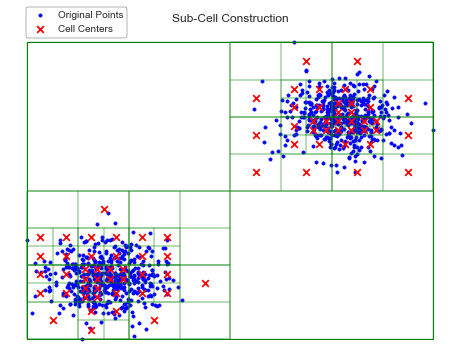

In [124]:
S = coreset_construction(X, blob_labels, k, d, eps, n_initial)

# K medians for blobs

In [145]:
def plot_kmedians_clusters(X, k, s, x_ticks=None, y_ticks=None, title='K-Medians Clustering'):
    '''
    Adaptation of code provided in https://www.kaggle.com/code/rafaelsaraivacampos/k-medians-clustering
    '''
    
    kmedians_instance = kmedians(X, X[np.random.permutation(X.shape[0])[:k],:], random_state=42)#seed
    kmedians_instance.process()
    
    clusters = kmedians_instance.get_clusters()
    y_kmedians = np.zeros([X.shape[0]])
    for i, cluster in enumerate(clusters):
        y_kmedians[cluster] = i
        
    plt.scatter(X[:, 0], X[:, 1], c=y_kmedians, s=s, cmap='bwr')
    centers = np.array(kmedians_instance.get_medians())
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=300, alpha=1, marker='X')
    plt.title(title)
    plt.grid(which='major')
    
    if x_ticks:
        plt.xticks(x_ticks)
    if y_ticks:
        plt.yticks(y_ticks)
    plt.show()
    
    return kmedians_instance, y_kmedians, centers

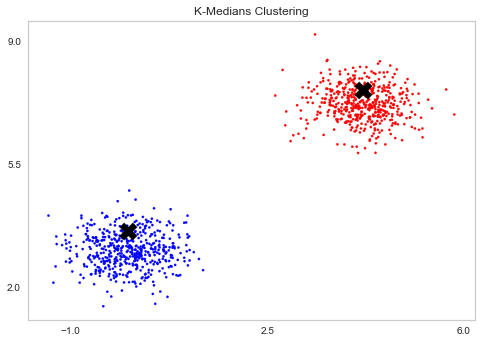

In [147]:
kmedians_instance, y_kmedians, centers = plot_kmedians_clusters(X, k, 5, x_ticks=[-1, 2.5, 6], y_ticks=[2, 5.5, 9])

In [69]:
def calculate_inertia(data, centroids, labels):
    inertia = 0.0
    for i in range(len(data)):
        cluster_center = centroids[labels[i]]
        inertia += np.sum((data[i] - cluster_center) ** 2)
    return inertia

In [90]:
silhouette_score = metrics.silhouette_score(X, y_kmedians, metric='manhattan')
inertia = calculate_inertia(X, centers, blob_labels)

print(f"Silhouette Score: {silhouette_score}") #how well-separated the clusters are
print(f"Inertia: {inertia}") # how far the points within a cluster are from the center of that cluster.

Silhouette Score: 0.8627793833245833
Inertia: 734.8139650000005


# K medians for coreset of blobs

In [131]:
def weighted_cs(X, weights, labels):
    '''Repeat coreset points to create a weighted data representation with labels
    '''
    weighted_X = np.repeat(X, weights, axis=0)
    weighted_labels = np.repeat(labels, weights, axis=0)
    
    return weighted_X, weighted_labels

coreset_array, coreset_labels = weighted_cs(np.array([item[0] for item in S]).reshape(-1, 2),
                                              [item[1] for item in S], [label for _, _, label in S])
coreset_array[0:5], coreset_labels[0:5]

(array([[-0.943375,  1.9305  ],
        [-0.943375,  1.9305  ],
        [-0.943375,  1.9305  ],
        [-0.943375,  1.9305  ],
        [-0.943375,  1.9305  ]]),
 array([1, 1, 1, 1, 1]))

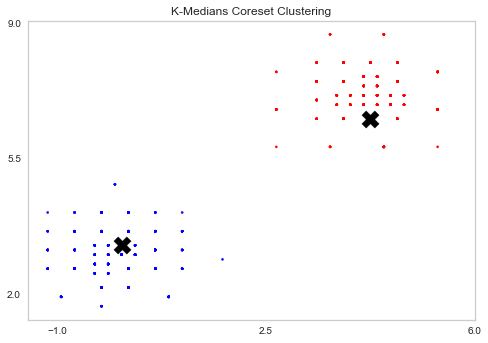

In [140]:
coreb_kmedians_instance, coreb_y_kmedians, coreb_centers = plot_kmedians_clusters(coreset_array, k, 5, 
                                                        x_ticks=[-1, 2.5, 6], y_ticks=[2, 5.5, 9], 
                                                        title='K-Medians Coreset Clustering')

In [141]:
silhouette_score = metrics.silhouette_score(coreset_array, coreb_y_kmedians, metric='manhattan')
inertia = calculate_inertia(coreset_array, coreb_centers, coreset_labels)

print(f"Silhouette Score: {silhouette_score}") #how well-separated the clusters are
print(f"Inertia: {inertia}") # how far the points within a cluster are from the center of that cluster.

Silhouette Score: 0.8539548862417786
Inertia: 31996.18760547937


# Half circles (moons)

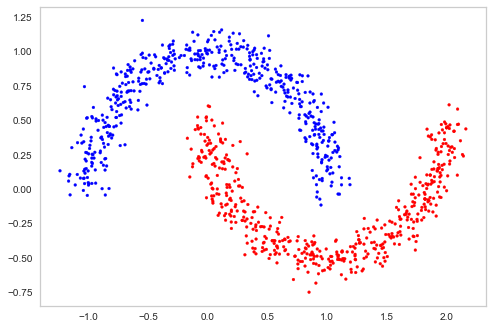

In [142]:
moons, moon_labels = sk.datasets.make_moons(n_samples=n, random_state=1, noise = 0.08)
moons = moons.round(3)
plt.scatter(moons[:, 0], moons[:, 1], c=moon_labels, cmap="bwr", s=8)
plt.grid(which='major');

The array is non-empty, proceeding with coreset construction algorithm
delta = 6
cs = 72
Number of guesses for opt approximation = 94

Iteration j = 0, with approximation Opt = (1+eps)^j = 1.0

Threshold value: 0.09375 Points in cell: 1000
Threshold value: 0.1875 Points in cell: 157
Threshold value: 0.375 Points in cell: 0
Threshold value: 0.375 Points in cell: 19
Threshold value: 0.75 Points in cell: 0
Threshold value: 0.75 Points in cell: 0
Threshold value: 0.75 Points in cell: 0
Threshold value: 0.75 Points in cell: 19
Threshold value: 1.5 Points in cell: 0
Threshold value: 1.5 Points in cell: 9
Threshold value: 3.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 3
Threshold value: 6.0 Points in cell: 0
Threshold value: 6.0 Points in cell: 0
Threshold value: 6.0 Points in cell: 2
Threshold value: 6.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 4
Threshold value: 6.0 Points in cell: 2
Threshold value: 6.0 Points in cell: 1
Thre

Threshold value: 3.0 Points in cell: 3
Threshold value: 6.0 Points in cell: 0
Threshold value: 6.0 Points in cell: 1
Threshold value: 6.0 Points in cell: 1
Threshold value: 6.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 8
Threshold value: 6.0 Points in cell: 3
Threshold value: 6.0 Points in cell: 2
Threshold value: 6.0 Points in cell: 1
Threshold value: 6.0 Points in cell: 2
Threshold value: 3.0 Points in cell: 4
Threshold value: 6.0 Points in cell: 1
Threshold value: 6.0 Points in cell: 0
Threshold value: 6.0 Points in cell: 1
Threshold value: 6.0 Points in cell: 2
Threshold value: 1.5 Points in cell: 15
Threshold value: 3.0 Points in cell: 2
Threshold value: 3.0 Points in cell: 4
Threshold value: 6.0 Points in cell: 1
Threshold value: 6.0 Points in cell: 0
Threshold value: 6.0 Points in cell: 2
Threshold value: 6.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 5
Threshold value: 6.0 Points in cell: 2
Threshold value: 6.0 Poi

Threshold value: 6.6 Points in cell: 0
Threshold value: 1.65 Points in cell: 2
Threshold value: 3.3 Points in cell: 0
Threshold value: 3.3 Points in cell: 1
Threshold value: 3.3 Points in cell: 0
Threshold value: 3.3 Points in cell: 1
Threshold value: 1.65 Points in cell: 14
Threshold value: 3.3 Points in cell: 1
Threshold value: 3.3 Points in cell: 6
Threshold value: 6.6 Points in cell: 2
Threshold value: 6.6 Points in cell: 1
Threshold value: 6.6 Points in cell: 0
Threshold value: 6.6 Points in cell: 3
Threshold value: 3.3 Points in cell: 0
Threshold value: 3.3 Points in cell: 7
Threshold value: 6.6 Points in cell: 2
Threshold value: 6.6 Points in cell: 0
Threshold value: 6.6 Points in cell: 0
Threshold value: 6.6 Points in cell: 5
Threshold value: 0.825 Points in cell: 7
Threshold value: 1.65 Points in cell: 2
Threshold value: 3.3 Points in cell: 0
Threshold value: 3.3 Points in cell: 0
Threshold value: 3.3 Points in cell: 1
Threshold value: 3.3 Points in cell: 1
Threshold value: 1.

Threshold value: 3.63 Points in cell: 0
Threshold value: 3.63 Points in cell: 5
Threshold value: 7.26 Points in cell: 2
Threshold value: 7.26 Points in cell: 1
Threshold value: 7.26 Points in cell: 2
Threshold value: 7.26 Points in cell: 0
Threshold value: 3.63 Points in cell: 5
Threshold value: 7.26 Points in cell: 0
Threshold value: 7.26 Points in cell: 2
Threshold value: 7.26 Points in cell: 1
Threshold value: 7.26 Points in cell: 2
Threshold value: 3.63 Points in cell: 3
Threshold value: 1.815 Points in cell: 2
Threshold value: 3.63 Points in cell: 1
Threshold value: 3.63 Points in cell: 0
Threshold value: 3.63 Points in cell: 1
Threshold value: 3.63 Points in cell: 0
Threshold value: 0.45375 Points in cell: 99
Threshold value: 0.9075 Points in cell: 26
Threshold value: 1.815 Points in cell: 2
Threshold value: 3.63 Points in cell: 0
Threshold value: 3.63 Points in cell: 2
Threshold value: 3.63 Points in cell: 0
Threshold value: 3.63 Points in cell: 0
Threshold value: 1.815 Points i

Threshold value: 7.986 Points in cell: 0
Threshold value: 7.986 Points in cell: 4
Threshold value: 7.986 Points in cell: 1
Threshold value: 7.986 Points in cell: 0
Threshold value: 3.993 Points in cell: 3
Threshold value: 3.993 Points in cell: 2
Threshold value: 1.9965 Points in cell: 4
Threshold value: 3.993 Points in cell: 3
Threshold value: 3.993 Points in cell: 1
Threshold value: 3.993 Points in cell: 0
Threshold value: 3.993 Points in cell: 0
Threshold value: 0.99825 Points in cell: 37
Threshold value: 1.9965 Points in cell: 15
Threshold value: 3.993 Points in cell: 4
Threshold value: 7.986 Points in cell: 2
Threshold value: 7.986 Points in cell: 1
Threshold value: 7.986 Points in cell: 1
Threshold value: 7.986 Points in cell: 0
Threshold value: 3.993 Points in cell: 6
Threshold value: 7.986 Points in cell: 2
Threshold value: 7.986 Points in cell: 3
Threshold value: 7.986 Points in cell: 0
Threshold value: 7.986 Points in cell: 1
Threshold value: 3.993 Points in cell: 4
Threshold 

Threshold value: 0.54904 Points in cell: 52
Threshold value: 1.09808 Points in cell: 4
Threshold value: 2.19615 Points in cell: 0
Threshold value: 2.19615 Points in cell: 0
Threshold value: 2.19615 Points in cell: 4
Threshold value: 4.3923 Points in cell: 0
Threshold value: 4.3923 Points in cell: 0
Threshold value: 4.3923 Points in cell: 1
Threshold value: 4.3923 Points in cell: 3
Threshold value: 2.19615 Points in cell: 0
Threshold value: 1.09808 Points in cell: 0
Threshold value: 1.09808 Points in cell: 45
Threshold value: 2.19615 Points in cell: 19
Threshold value: 4.3923 Points in cell: 3
Threshold value: 4.3923 Points in cell: 5
Threshold value: 8.7846 Points in cell: 1
Threshold value: 8.7846 Points in cell: 2
Threshold value: 8.7846 Points in cell: 1
Threshold value: 8.7846 Points in cell: 1
Threshold value: 4.3923 Points in cell: 5
Threshold value: 8.7846 Points in cell: 0
Threshold value: 8.7846 Points in cell: 2
Threshold value: 8.7846 Points in cell: 0
Threshold value: 8.784

Threshold value: 4.83153 Points in cell: 0
Threshold value: 4.83153 Points in cell: 2
Threshold value: 1.20788 Points in cell: 31
Threshold value: 2.41577 Points in cell: 11
Threshold value: 4.83153 Points in cell: 4
Threshold value: 4.83153 Points in cell: 1
Threshold value: 4.83153 Points in cell: 4
Threshold value: 4.83153 Points in cell: 2
Threshold value: 2.41577 Points in cell: 0
Threshold value: 2.41577 Points in cell: 18
Threshold value: 4.83153 Points in cell: 4
Threshold value: 4.83153 Points in cell: 5
Threshold value: 9.66306 Points in cell: 1
Threshold value: 9.66306 Points in cell: 1
Threshold value: 9.66306 Points in cell: 3
Threshold value: 9.66306 Points in cell: 0
Threshold value: 4.83153 Points in cell: 5
Threshold value: 9.66306 Points in cell: 2
Threshold value: 9.66306 Points in cell: 1
Threshold value: 9.66306 Points in cell: 0
Threshold value: 9.66306 Points in cell: 2
Threshold value: 4.83153 Points in cell: 4
Threshold value: 2.41577 Points in cell: 2
Threshol

Threshold value: 10.62937 Points in cell: 4
Threshold value: 10.62937 Points in cell: 2
Threshold value: 10.62937 Points in cell: 0
Threshold value: 5.31468 Points in cell: 8
Threshold value: 10.62937 Points in cell: 2
Threshold value: 10.62937 Points in cell: 5
Threshold value: 10.62937 Points in cell: 1
Threshold value: 10.62937 Points in cell: 0
Threshold value: 5.31468 Points in cell: 1
Threshold value: 5.31468 Points in cell: 2
Threshold value: 2.65734 Points in cell: 0
Threshold value: 2.65734 Points in cell: 3
Threshold value: 5.31468 Points in cell: 2
Threshold value: 5.31468 Points in cell: 1
Threshold value: 5.31468 Points in cell: 0
Threshold value: 5.31468 Points in cell: 0
Threshold value: 1.32867 Points in cell: 28
Threshold value: 2.65734 Points in cell: 11
Threshold value: 5.31468 Points in cell: 4
Threshold value: 5.31468 Points in cell: 3
Threshold value: 5.31468 Points in cell: 1
Threshold value: 5.31468 Points in cell: 3
Threshold value: 2.65734 Points in cell: 11
T

Threshold value: 6.43077 Points in cell: 5
Threshold value: 3.21538 Points in cell: 12
Threshold value: 6.43077 Points in cell: 5
Threshold value: 6.43077 Points in cell: 3
Threshold value: 6.43077 Points in cell: 2
Threshold value: 6.43077 Points in cell: 2
Threshold value: 3.21538 Points in cell: 18
Threshold value: 6.43077 Points in cell: 5
Threshold value: 6.43077 Points in cell: 6
Threshold value: 6.43077 Points in cell: 3
Threshold value: 6.43077 Points in cell: 4
Threshold value: 3.21538 Points in cell: 5
Threshold value: 6.43077 Points in cell: 3
Threshold value: 6.43077 Points in cell: 1
Threshold value: 6.43077 Points in cell: 1
Threshold value: 6.43077 Points in cell: 0
Threshold value: 1.60769 Points in cell: 16
Threshold value: 3.21538 Points in cell: 0
Threshold value: 3.21538 Points in cell: 6
Threshold value: 6.43077 Points in cell: 0
Threshold value: 6.43077 Points in cell: 2
Threshold value: 6.43077 Points in cell: 1
Threshold value: 6.43077 Points in cell: 3
Threshol

Threshold value: 7.07384 Points in cell: 4
Threshold value: 7.07384 Points in cell: 1
Threshold value: 3.53692 Points in cell: 18
Threshold value: 7.07384 Points in cell: 7
Threshold value: 7.07384 Points in cell: 8
Threshold value: 14.14769 Points in cell: 2
Threshold value: 14.14769 Points in cell: 5
Threshold value: 14.14769 Points in cell: 1
Threshold value: 14.14769 Points in cell: 0
Threshold value: 7.07384 Points in cell: 1
Threshold value: 7.07384 Points in cell: 2
Threshold value: 3.53692 Points in cell: 0
Threshold value: 3.53692 Points in cell: 3
Threshold value: 1.76846 Points in cell: 28
Threshold value: 3.53692 Points in cell: 11
Threshold value: 7.07384 Points in cell: 4
Threshold value: 7.07384 Points in cell: 3
Threshold value: 7.07384 Points in cell: 1
Threshold value: 7.07384 Points in cell: 3
Threshold value: 3.53692 Points in cell: 11
Threshold value: 7.07384 Points in cell: 5
Threshold value: 7.07384 Points in cell: 4
Threshold value: 7.07384 Points in cell: 2
Thr

Threshold value: 4.27968 Points in cell: 15
Threshold value: 8.55935 Points in cell: 2
Threshold value: 8.55935 Points in cell: 7
Threshold value: 8.55935 Points in cell: 3
Threshold value: 8.55935 Points in cell: 3
Threshold value: 2.13984 Points in cell: 0
Threshold value: 2.13984 Points in cell: 2
Threshold value: 1.06992 Points in cell: 141
Threshold value: 2.13984 Points in cell: 38
Threshold value: 4.27968 Points in cell: 4
Threshold value: 4.27968 Points in cell: 3
Threshold value: 4.27968 Points in cell: 16
Threshold value: 8.55935 Points in cell: 3
Threshold value: 8.55935 Points in cell: 1
Threshold value: 8.55935 Points in cell: 8
Threshold value: 8.55935 Points in cell: 4
Threshold value: 4.27968 Points in cell: 15
Threshold value: 8.55935 Points in cell: 2
Threshold value: 8.55935 Points in cell: 4
Threshold value: 8.55935 Points in cell: 5
Threshold value: 8.55935 Points in cell: 4
Threshold value: 2.13984 Points in cell: 43
Threshold value: 4.27968 Points in cell: 2
Thre

Threshold value: 10.35681 Points in cell: 7
Threshold value: 10.35681 Points in cell: 5
Threshold value: 5.17841 Points in cell: 3
Threshold value: 1.2946 Points in cell: 44
Threshold value: 2.5892 Points in cell: 20
Threshold value: 5.17841 Points in cell: 0
Threshold value: 5.17841 Points in cell: 11
Threshold value: 10.35681 Points in cell: 1
Threshold value: 10.35681 Points in cell: 5
Threshold value: 10.35681 Points in cell: 0
Threshold value: 10.35681 Points in cell: 5
Threshold value: 5.17841 Points in cell: 0
Threshold value: 5.17841 Points in cell: 9
Threshold value: 10.35681 Points in cell: 1
Threshold value: 10.35681 Points in cell: 3
Threshold value: 10.35681 Points in cell: 4
Threshold value: 10.35681 Points in cell: 1
Threshold value: 2.5892 Points in cell: 15
Threshold value: 5.17841 Points in cell: 9
Threshold value: 10.35681 Points in cell: 2
Threshold value: 10.35681 Points in cell: 1
Threshold value: 10.35681 Points in cell: 4
Threshold value: 10.35681 Points in cell

Threshold value: 12.53174 Points in cell: 4
Threshold value: 12.53174 Points in cell: 2
Threshold value: 12.53174 Points in cell: 4
Threshold value: 12.53174 Points in cell: 1
Threshold value: 6.26587 Points in cell: 18
Threshold value: 12.53174 Points in cell: 7
Threshold value: 12.53174 Points in cell: 8
Threshold value: 12.53174 Points in cell: 1
Threshold value: 12.53174 Points in cell: 2
Threshold value: 6.26587 Points in cell: 0
Threshold value: 6.26587 Points in cell: 3
Threshold value: 3.13294 Points in cell: 28
Threshold value: 6.26587 Points in cell: 11
Threshold value: 12.53174 Points in cell: 4
Threshold value: 12.53174 Points in cell: 3
Threshold value: 12.53174 Points in cell: 1
Threshold value: 12.53174 Points in cell: 3
Threshold value: 6.26587 Points in cell: 11
Threshold value: 12.53174 Points in cell: 5
Threshold value: 12.53174 Points in cell: 4
Threshold value: 12.53174 Points in cell: 2
Threshold value: 12.53174 Points in cell: 0
Threshold value: 6.26587 Points in

Threshold value: 0.52124 Points in cell: 1000
Threshold value: 1.04248 Points in cell: 157
Threshold value: 2.08497 Points in cell: 0
Threshold value: 2.08497 Points in cell: 19
Threshold value: 4.16994 Points in cell: 0
Threshold value: 4.16994 Points in cell: 0
Threshold value: 4.16994 Points in cell: 0
Threshold value: 4.16994 Points in cell: 19
Threshold value: 8.33988 Points in cell: 0
Threshold value: 8.33988 Points in cell: 9
Threshold value: 16.67975 Points in cell: 1
Threshold value: 16.67975 Points in cell: 3
Threshold value: 16.67975 Points in cell: 1
Threshold value: 16.67975 Points in cell: 4
Threshold value: 8.33988 Points in cell: 1
Threshold value: 8.33988 Points in cell: 9
Threshold value: 16.67975 Points in cell: 1
Threshold value: 16.67975 Points in cell: 1
Threshold value: 16.67975 Points in cell: 1
Threshold value: 16.67975 Points in cell: 6
Threshold value: 2.08497 Points in cell: 41
Threshold value: 4.16994 Points in cell: 4
Threshold value: 4.16994 Points in cel

Threshold value: 5.04562 Points in cell: 41
Threshold value: 10.09125 Points in cell: 19
Threshold value: 20.1825 Points in cell: 6
Threshold value: 20.1825 Points in cell: 5
Threshold value: 20.1825 Points in cell: 2
Threshold value: 20.1825 Points in cell: 6
Threshold value: 10.09125 Points in cell: 4
Threshold value: 10.09125 Points in cell: 12
Threshold value: 20.1825 Points in cell: 0
Threshold value: 20.1825 Points in cell: 9
Threshold value: 20.1825 Points in cell: 1
Threshold value: 20.1825 Points in cell: 2
Threshold value: 10.09125 Points in cell: 6
Threshold value: 1.26141 Points in cell: 329
Threshold value: 2.52281 Points in cell: 91
Threshold value: 5.04562 Points in cell: 35
Threshold value: 10.09125 Points in cell: 4
Threshold value: 10.09125 Points in cell: 15
Threshold value: 20.1825 Points in cell: 7
Threshold value: 20.1825 Points in cell: 2
Threshold value: 20.1825 Points in cell: 2
Threshold value: 20.1825 Points in cell: 4
Threshold value: 10.09125 Points in cell

Threshold value: 13.43145 Points in cell: 2
Threshold value: 13.43145 Points in cell: 0
Threshold value: 13.43145 Points in cell: 5
Threshold value: 13.43145 Points in cell: 0
Threshold value: 6.71573 Points in cell: 13
Threshold value: 13.43145 Points in cell: 0
Threshold value: 13.43145 Points in cell: 11
Threshold value: 13.43145 Points in cell: 0
Threshold value: 13.43145 Points in cell: 2
Threshold value: 6.71573 Points in cell: 36
Threshold value: 13.43145 Points in cell: 11
Threshold value: 13.43145 Points in cell: 1
Threshold value: 13.43145 Points in cell: 21
Threshold value: 26.86291 Points in cell: 6
Threshold value: 26.86291 Points in cell: 3
Threshold value: 26.86291 Points in cell: 7
Threshold value: 26.86291 Points in cell: 5
Threshold value: 13.43145 Points in cell: 3
Threshold value: 3.35786 Points in cell: 44
Threshold value: 6.71573 Points in cell: 20
Threshold value: 13.43145 Points in cell: 0
Threshold value: 13.43145 Points in cell: 11
Threshold value: 13.43145 Po

Threshold value: 19.66499 Points in cell: 2
Threshold value: 19.66499 Points in cell: 5
Threshold value: 4.91625 Points in cell: 52
Threshold value: 9.8325 Points in cell: 4
Threshold value: 9.8325 Points in cell: 0
Threshold value: 9.8325 Points in cell: 45
Threshold value: 19.66499 Points in cell: 19
Threshold value: 19.66499 Points in cell: 2
Threshold value: 19.66499 Points in cell: 9
Threshold value: 19.66499 Points in cell: 15
Threshold value: 9.8325 Points in cell: 3
Threshold value: 4.91625 Points in cell: 40
Threshold value: 9.8325 Points in cell: 4
Threshold value: 9.8325 Points in cell: 7
Threshold value: 9.8325 Points in cell: 2
Threshold value: 9.8325 Points in cell: 27
Threshold value: 19.66499 Points in cell: 8
Threshold value: 19.66499 Points in cell: 4
Threshold value: 19.66499 Points in cell: 13
Threshold value: 19.66499 Points in cell: 2
Threshold value: 4.91625 Points in cell: 99
Threshold value: 9.8325 Points in cell: 26
Threshold value: 19.66499 Points in cell: 2


Threshold value: 3.95883 Points in cell: 180
Threshold value: 7.91767 Points in cell: 95
Threshold value: 15.83533 Points in cell: 11
Threshold value: 15.83533 Points in cell: 38
Threshold value: 31.67067 Points in cell: 18
Threshold value: 31.67067 Points in cell: 0
Threshold value: 31.67067 Points in cell: 20
Threshold value: 31.67067 Points in cell: 0
Threshold value: 15.83533 Points in cell: 38
Threshold value: 31.67067 Points in cell: 1
Threshold value: 31.67067 Points in cell: 13
Threshold value: 31.67067 Points in cell: 11
Threshold value: 31.67067 Points in cell: 13
Threshold value: 15.83533 Points in cell: 8
Threshold value: 7.91767 Points in cell: 43
Threshold value: 15.83533 Points in cell: 0
Threshold value: 15.83533 Points in cell: 40
Threshold value: 31.67067 Points in cell: 6
Threshold value: 31.67067 Points in cell: 15
Threshold value: 31.67067 Points in cell: 5
Threshold value: 31.67067 Points in cell: 14
Threshold value: 15.83533 Points in cell: 0
Threshold value: 15.

Threshold value: 3.85732 Points in cell: 1000
Threshold value: 7.71465 Points in cell: 157
Threshold value: 15.42929 Points in cell: 0
Threshold value: 15.42929 Points in cell: 19
Threshold value: 30.85858 Points in cell: 0
Threshold value: 30.85858 Points in cell: 0
Threshold value: 30.85858 Points in cell: 0
Threshold value: 30.85858 Points in cell: 19
Threshold value: 15.42929 Points in cell: 41
Threshold value: 30.85858 Points in cell: 4
Threshold value: 30.85858 Points in cell: 0
Threshold value: 30.85858 Points in cell: 37
Threshold value: 61.71717 Points in cell: 9
Threshold value: 61.71717 Points in cell: 8
Threshold value: 61.71717 Points in cell: 5
Threshold value: 61.71717 Points in cell: 15
Threshold value: 30.85858 Points in cell: 0
Threshold value: 15.42929 Points in cell: 97
Threshold value: 30.85858 Points in cell: 2
Threshold value: 30.85858 Points in cell: 48
Threshold value: 61.71717 Points in cell: 13
Threshold value: 61.71717 Points in cell: 12
Threshold value: 61.

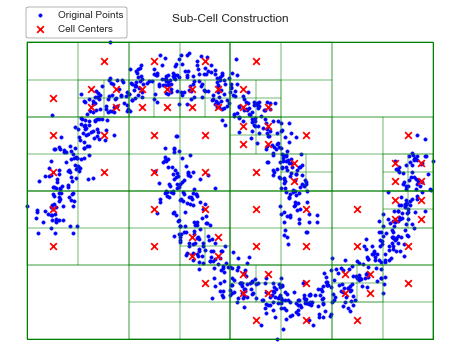

In [143]:
S_moons = coreset_construction(moons, moon_labels, k, d, eps, len(moons)); 

# K medians for moons

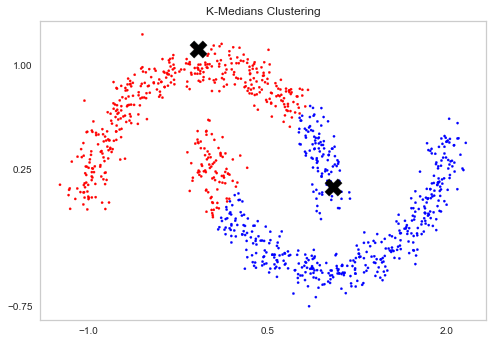

In [150]:
moons_kmedians_instance, moons_y_kmedians, moons_centers = plot_kmedians_clusters(moons, k, 5, x_ticks=[-1,0.5,2], y_ticks=[-0.75,0.25,1])

In [153]:
silhouette_score = metrics.silhouette_score(moons, moons_y_kmedians, metric='manhattan')
inertia = calculate_inertia(moons, moons_centers, moon_labels)

print(f"Silhouette Score: {silhouette_score}") #how well-separated the clusters are
print(f"Inertia: {inertia}") # how far the points within a cluster are from the center of that cluster.

Silhouette Score: 0.48556829803072427
Inertia: 2656.647873999999


# K medians for coreset of moons

In [154]:
corem_coreset_array, corem_coreset_labels = weighted_cs(np.array([item[0] for item in S_moons]).reshape(-1, 2),
                                              [item[1] for item in S_moons], [label for _, _, label in S_moons])

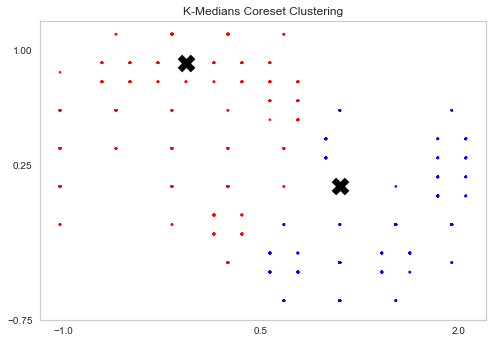

In [157]:
corem_kmedians_instance, corem_y_kmedians, corem_centers = plot_kmedians_clusters(corem_coreset_array, k, 5, 
                                                        x_ticks=[-1,0.5,2], y_ticks=[-0.75,0.25,1], 
                                                        title='K-Medians Coreset Clustering')

In [158]:
silhouette_score = metrics.silhouette_score(corem_coreset_array, corem_y_kmedians, metric='manhattan')
inertia = calculate_inertia(corem_coreset_array, corem_centers, corem_coreset_labels)

print(f"Silhouette Score: {silhouette_score}") #how well-separated the clusters are
print(f"Inertia: {inertia}") # how far the points within a cluster are from the center of that cluster.

Silhouette Score: 0.4838207619254288
Inertia: 2476.5679757109347


# Circles

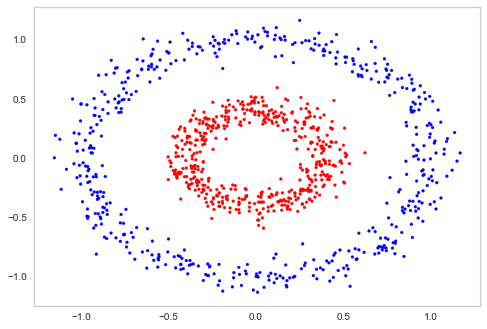

In [159]:
circles, circles_labels = sk.datasets.make_circles(n_samples=n, random_state=1, noise = 0.07, factor=0.4)
circles = circles.round(3)
plt.scatter(circles[:, 0], circles[:, 1], c=circles_labels, cmap="bwr", s=8)
plt.grid(which='major');

The array is non-empty, proceeding with coreset construction algorithm
delta = 6
cs = 72
Number of guesses for opt approximation = 94

Iteration j = 0, with approximation Opt = (1+eps)^j = 1.0

Threshold value: 0.09375 Points in cell: 1000
Threshold value: 0.1875 Points in cell: 253
Threshold value: 0.375 Points in cell: 25
Threshold value: 0.75 Points in cell: 0
Threshold value: 0.75 Points in cell: 3
Threshold value: 1.5 Points in cell: 0
Threshold value: 1.5 Points in cell: 0
Threshold value: 1.5 Points in cell: 0
Threshold value: 1.5 Points in cell: 3
Threshold value: 3.0 Points in cell: 0
Threshold value: 3.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 1
Threshold value: 0.75 Points in cell: 4
Threshold value: 1.5 Points in cell: 0
Threshold value: 1.5 Points in cell: 1
Threshold value: 1.5 Points in cell: 0
Threshold value: 1.5 Points in cell: 3
Threshold value: 3.0 Points in cell: 0
Threshold value: 3.0 Points in cell: 1
Threshol

Threshold value: 0.75 Points in cell: 22
Threshold value: 1.5 Points in cell: 6
Threshold value: 3.0 Points in cell: 0
Threshold value: 3.0 Points in cell: 2
Threshold value: 3.0 Points in cell: 2
Threshold value: 3.0 Points in cell: 2
Threshold value: 1.5 Points in cell: 2
Threshold value: 3.0 Points in cell: 0
Threshold value: 3.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 0
Threshold value: 1.5 Points in cell: 4
Threshold value: 3.0 Points in cell: 2
Threshold value: 3.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 1
Threshold value: 3.0 Points in cell: 0
Threshold value: 1.5 Points in cell: 10
Threshold value: 3.0 Points in cell: 2
Threshold value: 3.0 Points in cell: 5
Threshold value: 6.0 Points in cell: 1
Threshold value: 6.0 Points in cell: 1
Threshold value: 6.0 Points in cell: 1
Threshold value: 6.0 Points in cell: 2
Threshold value: 3.0 Points in cell: 2
Threshold value: 3.0 Points in cell: 1
Threshold value: 0.75 

Threshold value: 6.6 Points in cell: 2
Threshold value: 6.6 Points in cell: 1
Threshold value: 6.6 Points in cell: 0
Threshold value: 1.65 Points in cell: 8
Threshold value: 3.3 Points in cell: 3
Threshold value: 3.3 Points in cell: 0
Threshold value: 3.3 Points in cell: 4
Threshold value: 6.6 Points in cell: 0
Threshold value: 6.6 Points in cell: 3
Threshold value: 6.6 Points in cell: 0
Threshold value: 6.6 Points in cell: 1
Threshold value: 3.3 Points in cell: 1
Threshold value: 0.4125 Points in cell: 47
Threshold value: 0.825 Points in cell: 8
Threshold value: 1.65 Points in cell: 0
Threshold value: 1.65 Points in cell: 5
Threshold value: 3.3 Points in cell: 1
Threshold value: 3.3 Points in cell: 0
Threshold value: 3.3 Points in cell: 0
Threshold value: 3.3 Points in cell: 4
Threshold value: 6.6 Points in cell: 0
Threshold value: 6.6 Points in cell: 1
Threshold value: 6.6 Points in cell: 2
Threshold value: 6.6 Points in cell: 1
Threshold value: 1.65 Points in cell: 0
Threshold value

Threshold value: 3.63 Points in cell: 2
Threshold value: 3.63 Points in cell: 2
Threshold value: 1.815 Points in cell: 2
Threshold value: 3.63 Points in cell: 0
Threshold value: 3.63 Points in cell: 1
Threshold value: 3.63 Points in cell: 1
Threshold value: 3.63 Points in cell: 0
Threshold value: 1.815 Points in cell: 7
Threshold value: 3.63 Points in cell: 2
Threshold value: 3.63 Points in cell: 1
Threshold value: 3.63 Points in cell: 1
Threshold value: 3.63 Points in cell: 3
Threshold value: 1.815 Points in cell: 6
Threshold value: 3.63 Points in cell: 2
Threshold value: 3.63 Points in cell: 1
Threshold value: 3.63 Points in cell: 0
Threshold value: 3.63 Points in cell: 3
Threshold value: 0.9075 Points in cell: 5
Threshold value: 1.815 Points in cell: 2
Threshold value: 3.63 Points in cell: 0
Threshold value: 3.63 Points in cell: 2
Threshold value: 3.63 Points in cell: 0
Threshold value: 3.63 Points in cell: 0
Threshold value: 1.815 Points in cell: 1
Threshold value: 1.815 Points in 

Threshold value: 3.993 Points in cell: 2
Threshold value: 3.993 Points in cell: 1
Threshold value: 3.993 Points in cell: 7
Threshold value: 7.986 Points in cell: 1
Threshold value: 7.986 Points in cell: 2
Threshold value: 7.986 Points in cell: 2
Threshold value: 7.986 Points in cell: 2
Threshold value: 0.99825 Points in cell: 8
Threshold value: 1.9965 Points in cell: 6
Threshold value: 3.993 Points in cell: 0
Threshold value: 3.993 Points in cell: 2
Threshold value: 3.993 Points in cell: 2
Threshold value: 3.993 Points in cell: 2
Threshold value: 1.9965 Points in cell: 0
Threshold value: 1.9965 Points in cell: 2
Threshold value: 3.993 Points in cell: 2
Threshold value: 3.993 Points in cell: 0
Threshold value: 3.993 Points in cell: 0
Threshold value: 3.993 Points in cell: 0
Threshold value: 1.9965 Points in cell: 0
Threshold value: 0.99825 Points in cell: 21
Threshold value: 1.9965 Points in cell: 2
Threshold value: 3.993 Points in cell: 1
Threshold value: 3.993 Points in cell: 0
Thresh


Iteration j = 4, with approximation Opt = (1+eps)^j = 1.4641000000000004

Threshold value: 0.13726 Points in cell: 1000
Threshold value: 0.27452 Points in cell: 253
Threshold value: 0.54904 Points in cell: 25
Threshold value: 1.09808 Points in cell: 0
Threshold value: 1.09808 Points in cell: 3
Threshold value: 2.19615 Points in cell: 0
Threshold value: 2.19615 Points in cell: 0
Threshold value: 2.19615 Points in cell: 0
Threshold value: 2.19615 Points in cell: 3
Threshold value: 4.3923 Points in cell: 0
Threshold value: 4.3923 Points in cell: 1
Threshold value: 4.3923 Points in cell: 1
Threshold value: 4.3923 Points in cell: 1
Threshold value: 1.09808 Points in cell: 4
Threshold value: 2.19615 Points in cell: 0
Threshold value: 2.19615 Points in cell: 1
Threshold value: 2.19615 Points in cell: 0
Threshold value: 2.19615 Points in cell: 3
Threshold value: 4.3923 Points in cell: 0
Threshold value: 4.3923 Points in cell: 1
Threshold value: 4.3923 Points in cell: 0
Threshold value: 4.3923

Threshold value: 0.30197 Points in cell: 253
Threshold value: 0.60394 Points in cell: 25
Threshold value: 1.20788 Points in cell: 0
Threshold value: 1.20788 Points in cell: 3
Threshold value: 2.41577 Points in cell: 0
Threshold value: 2.41577 Points in cell: 0
Threshold value: 2.41577 Points in cell: 0
Threshold value: 2.41577 Points in cell: 3
Threshold value: 4.83153 Points in cell: 0
Threshold value: 4.83153 Points in cell: 1
Threshold value: 4.83153 Points in cell: 1
Threshold value: 4.83153 Points in cell: 1
Threshold value: 1.20788 Points in cell: 4
Threshold value: 2.41577 Points in cell: 0
Threshold value: 2.41577 Points in cell: 1
Threshold value: 2.41577 Points in cell: 0
Threshold value: 2.41577 Points in cell: 3
Threshold value: 4.83153 Points in cell: 0
Threshold value: 4.83153 Points in cell: 1
Threshold value: 4.83153 Points in cell: 0
Threshold value: 4.83153 Points in cell: 2
Threshold value: 1.20788 Points in cell: 18
Threshold value: 2.41577 Points in cell: 4
Thresho

Threshold value: 2.65734 Points in cell: 10
Threshold value: 5.31468 Points in cell: 2
Threshold value: 5.31468 Points in cell: 1
Threshold value: 5.31468 Points in cell: 6
Threshold value: 10.62937 Points in cell: 0
Threshold value: 10.62937 Points in cell: 3
Threshold value: 10.62937 Points in cell: 2
Threshold value: 10.62937 Points in cell: 1
Threshold value: 5.31468 Points in cell: 1
Threshold value: 1.32867 Points in cell: 22
Threshold value: 2.65734 Points in cell: 5
Threshold value: 5.31468 Points in cell: 1
Threshold value: 5.31468 Points in cell: 1
Threshold value: 5.31468 Points in cell: 2
Threshold value: 5.31468 Points in cell: 1
Threshold value: 2.65734 Points in cell: 5
Threshold value: 5.31468 Points in cell: 2
Threshold value: 5.31468 Points in cell: 1
Threshold value: 5.31468 Points in cell: 1
Threshold value: 5.31468 Points in cell: 1
Threshold value: 2.65734 Points in cell: 5
Threshold value: 5.31468 Points in cell: 2
Threshold value: 5.31468 Points in cell: 0
Thres

Threshold value: 5.84615 Points in cell: 0
Threshold value: 2.92308 Points in cell: 4
Threshold value: 5.84615 Points in cell: 0
Threshold value: 5.84615 Points in cell: 1
Threshold value: 5.84615 Points in cell: 1
Threshold value: 5.84615 Points in cell: 2
Threshold value: 1.46154 Points in cell: 19
Threshold value: 2.92308 Points in cell: 4
Threshold value: 5.84615 Points in cell: 0
Threshold value: 5.84615 Points in cell: 0
Threshold value: 5.84615 Points in cell: 2
Threshold value: 5.84615 Points in cell: 2
Threshold value: 2.92308 Points in cell: 2
Threshold value: 2.92308 Points in cell: 7
Threshold value: 5.84615 Points in cell: 2
Threshold value: 5.84615 Points in cell: 1
Threshold value: 5.84615 Points in cell: 1
Threshold value: 5.84615 Points in cell: 3
Threshold value: 2.92308 Points in cell: 6
Threshold value: 5.84615 Points in cell: 2
Threshold value: 5.84615 Points in cell: 1
Threshold value: 5.84615 Points in cell: 0
Threshold value: 5.84615 Points in cell: 3
Threshold 

Threshold value: 3.21538 Points in cell: 7
Threshold value: 6.43077 Points in cell: 0
Threshold value: 6.43077 Points in cell: 1
Threshold value: 6.43077 Points in cell: 1
Threshold value: 6.43077 Points in cell: 5
Threshold value: 3.21538 Points in cell: 2
Threshold value: 3.21538 Points in cell: 7
Threshold value: 6.43077 Points in cell: 1
Threshold value: 6.43077 Points in cell: 2
Threshold value: 6.43077 Points in cell: 2
Threshold value: 6.43077 Points in cell: 2
Threshold value: 3.21538 Points in cell: 2
Threshold value: 0.40192 Points in cell: 245
Threshold value: 0.80385 Points in cell: 51
Threshold value: 1.60769 Points in cell: 20
Threshold value: 3.21538 Points in cell: 3
Threshold value: 3.21538 Points in cell: 8
Threshold value: 6.43077 Points in cell: 4
Threshold value: 6.43077 Points in cell: 1
Threshold value: 6.43077 Points in cell: 3
Threshold value: 6.43077 Points in cell: 0
Threshold value: 3.21538 Points in cell: 4
Threshold value: 6.43077 Points in cell: 2
Thresho

Threshold value: 7.07384 Points in cell: 3
Threshold value: 7.07384 Points in cell: 3
Threshold value: 3.53692 Points in cell: 6
Threshold value: 7.07384 Points in cell: 4
Threshold value: 7.07384 Points in cell: 2
Threshold value: 7.07384 Points in cell: 0
Threshold value: 7.07384 Points in cell: 0
Threshold value: 3.53692 Points in cell: 5
Threshold value: 7.07384 Points in cell: 4
Threshold value: 7.07384 Points in cell: 0
Threshold value: 7.07384 Points in cell: 1
Threshold value: 7.07384 Points in cell: 0
Threshold value: 1.76846 Points in cell: 3
Threshold value: 3.53692 Points in cell: 3
Threshold value: 3.53692 Points in cell: 0
Threshold value: 3.53692 Points in cell: 0
Threshold value: 3.53692 Points in cell: 0
Threshold value: 1.76846 Points in cell: 2
Threshold value: 3.53692 Points in cell: 2
Threshold value: 3.53692 Points in cell: 0
Threshold value: 3.53692 Points in cell: 0
Threshold value: 3.53692 Points in cell: 0
Threshold value: 1.76846 Points in cell: 0

Iteration 

Threshold value: 1.06992 Points in cell: 30
Threshold value: 2.13984 Points in cell: 0
Threshold value: 2.13984 Points in cell: 0
Threshold value: 2.13984 Points in cell: 28
Threshold value: 4.27968 Points in cell: 9
Threshold value: 8.55935 Points in cell: 2
Threshold value: 8.55935 Points in cell: 3
Threshold value: 8.55935 Points in cell: 0
Threshold value: 8.55935 Points in cell: 4
Threshold value: 4.27968 Points in cell: 8
Threshold value: 8.55935 Points in cell: 2
Threshold value: 8.55935 Points in cell: 1
Threshold value: 8.55935 Points in cell: 5
Threshold value: 8.55935 Points in cell: 0
Threshold value: 4.27968 Points in cell: 5
Threshold value: 8.55935 Points in cell: 1
Threshold value: 8.55935 Points in cell: 1
Threshold value: 8.55935 Points in cell: 1
Threshold value: 8.55935 Points in cell: 2
Threshold value: 4.27968 Points in cell: 6
Threshold value: 8.55935 Points in cell: 3
Threshold value: 8.55935 Points in cell: 0
Threshold value: 8.55935 Points in cell: 2
Threshold


Iteration j = 13, with approximation Opt = (1+eps)^j = 3.452271214393104

Threshold value: 0.32365 Points in cell: 1000
Threshold value: 0.6473 Points in cell: 253
Threshold value: 1.2946 Points in cell: 25
Threshold value: 2.5892 Points in cell: 0
Threshold value: 2.5892 Points in cell: 3
Threshold value: 5.17841 Points in cell: 0
Threshold value: 5.17841 Points in cell: 0
Threshold value: 5.17841 Points in cell: 0
Threshold value: 5.17841 Points in cell: 3
Threshold value: 2.5892 Points in cell: 4
Threshold value: 5.17841 Points in cell: 0
Threshold value: 5.17841 Points in cell: 1
Threshold value: 5.17841 Points in cell: 0
Threshold value: 5.17841 Points in cell: 3
Threshold value: 2.5892 Points in cell: 18
Threshold value: 5.17841 Points in cell: 4
Threshold value: 5.17841 Points in cell: 3
Threshold value: 5.17841 Points in cell: 6
Threshold value: 10.35681 Points in cell: 3
Threshold value: 10.35681 Points in cell: 3
Threshold value: 10.35681 Points in cell: 0
Threshold value: 1

Threshold value: 5.69625 Points in cell: 1
Threshold value: 5.69625 Points in cell: 0
Threshold value: 5.69625 Points in cell: 0
Threshold value: 5.69625 Points in cell: 2
Threshold value: 2.84812 Points in cell: 22
Threshold value: 5.69625 Points in cell: 6
Threshold value: 11.3925 Points in cell: 3
Threshold value: 11.3925 Points in cell: 0
Threshold value: 11.3925 Points in cell: 1
Threshold value: 11.3925 Points in cell: 2
Threshold value: 5.69625 Points in cell: 6
Threshold value: 11.3925 Points in cell: 3
Threshold value: 11.3925 Points in cell: 1
Threshold value: 11.3925 Points in cell: 2
Threshold value: 11.3925 Points in cell: 0
Threshold value: 5.69625 Points in cell: 8
Threshold value: 11.3925 Points in cell: 1
Threshold value: 11.3925 Points in cell: 2
Threshold value: 11.3925 Points in cell: 1
Threshold value: 11.3925 Points in cell: 4
Threshold value: 5.69625 Points in cell: 2
Threshold value: 2.84812 Points in cell: 3
Threshold value: 5.69625 Points in cell: 0
Threshold 


Threshold value: 0.47386 Points in cell: 1000
Threshold value: 0.94771 Points in cell: 253
Threshold value: 1.89543 Points in cell: 25
Threshold value: 3.79085 Points in cell: 0
Threshold value: 3.79085 Points in cell: 3
Threshold value: 3.79085 Points in cell: 4
Threshold value: 7.58171 Points in cell: 0
Threshold value: 7.58171 Points in cell: 1
Threshold value: 7.58171 Points in cell: 0
Threshold value: 7.58171 Points in cell: 3
Threshold value: 3.79085 Points in cell: 18
Threshold value: 7.58171 Points in cell: 4
Threshold value: 7.58171 Points in cell: 3
Threshold value: 7.58171 Points in cell: 6
Threshold value: 7.58171 Points in cell: 5
Threshold value: 1.89543 Points in cell: 49
Threshold value: 3.79085 Points in cell: 19
Threshold value: 7.58171 Points in cell: 0
Threshold value: 7.58171 Points in cell: 1
Threshold value: 7.58171 Points in cell: 8
Threshold value: 15.16341 Points in cell: 1
Threshold value: 15.16341 Points in cell: 2
Threshold value: 15.16341 Points in cell: 

Threshold value: 9.17386 Points in cell: 10
Threshold value: 18.34773 Points in cell: 5
Threshold value: 18.34773 Points in cell: 2
Threshold value: 18.34773 Points in cell: 2
Threshold value: 18.34773 Points in cell: 1
Threshold value: 9.17386 Points in cell: 1
Threshold value: 4.58693 Points in cell: 4
Threshold value: 4.58693 Points in cell: 18
Threshold value: 9.17386 Points in cell: 7
Threshold value: 9.17386 Points in cell: 2
Threshold value: 9.17386 Points in cell: 7
Threshold value: 9.17386 Points in cell: 2
Threshold value: 1.14673 Points in cell: 245
Threshold value: 2.29347 Points in cell: 51
Threshold value: 4.58693 Points in cell: 20
Threshold value: 9.17386 Points in cell: 3
Threshold value: 9.17386 Points in cell: 8
Threshold value: 9.17386 Points in cell: 4
Threshold value: 9.17386 Points in cell: 5
Threshold value: 4.58693 Points in cell: 0
Threshold value: 4.58693 Points in cell: 14
Threshold value: 9.17386 Points in cell: 0
Threshold value: 9.17386 Points in cell: 7


Threshold value: 12.21041 Points in cell: 6
Threshold value: 6.10521 Points in cell: 2
Threshold value: 3.0526 Points in cell: 132
Threshold value: 6.10521 Points in cell: 59
Threshold value: 12.21041 Points in cell: 9
Threshold value: 12.21041 Points in cell: 4
Threshold value: 12.21041 Points in cell: 25
Threshold value: 24.42082 Points in cell: 5
Threshold value: 24.42082 Points in cell: 8
Threshold value: 24.42082 Points in cell: 7
Threshold value: 24.42082 Points in cell: 5
Threshold value: 12.21041 Points in cell: 21
Threshold value: 24.42082 Points in cell: 7
Threshold value: 24.42082 Points in cell: 4
Threshold value: 24.42082 Points in cell: 6
Threshold value: 24.42082 Points in cell: 4
Threshold value: 6.10521 Points in cell: 10
Threshold value: 12.21041 Points in cell: 0
Threshold value: 12.21041 Points in cell: 0
Threshold value: 12.21041 Points in cell: 9
Threshold value: 12.21041 Points in cell: 1
Threshold value: 6.10521 Points in cell: 15
Threshold value: 12.21041 Point

Threshold value: 16.25206 Points in cell: 2
Threshold value: 16.25206 Points in cell: 4
Threshold value: 16.25206 Points in cell: 10
Threshold value: 8.12603 Points in cell: 0
Threshold value: 8.12603 Points in cell: 3
Threshold value: 4.06301 Points in cell: 45
Threshold value: 8.12603 Points in cell: 7
Threshold value: 8.12603 Points in cell: 2
Threshold value: 8.12603 Points in cell: 14
Threshold value: 16.25206 Points in cell: 5
Threshold value: 16.25206 Points in cell: 8
Threshold value: 16.25206 Points in cell: 0
Threshold value: 16.25206 Points in cell: 1
Threshold value: 8.12603 Points in cell: 22
Threshold value: 16.25206 Points in cell: 11
Threshold value: 16.25206 Points in cell: 4
Threshold value: 16.25206 Points in cell: 2
Threshold value: 16.25206 Points in cell: 5
Threshold value: 2.03151 Points in cell: 240
Threshold value: 4.06301 Points in cell: 114
Threshold value: 8.12603 Points in cell: 18
Threshold value: 16.25206 Points in cell: 0
Threshold value: 16.25206 Points

Threshold value: 2.97433 Points in cell: 240
Threshold value: 5.94866 Points in cell: 114
Threshold value: 11.89732 Points in cell: 18
Threshold value: 23.79464 Points in cell: 0
Threshold value: 23.79464 Points in cell: 3
Threshold value: 23.79464 Points in cell: 4
Threshold value: 23.79464 Points in cell: 11
Threshold value: 11.89732 Points in cell: 40
Threshold value: 23.79464 Points in cell: 21
Threshold value: 23.79464 Points in cell: 5
Threshold value: 23.79464 Points in cell: 13
Threshold value: 23.79464 Points in cell: 1
Threshold value: 11.89732 Points in cell: 46
Threshold value: 23.79464 Points in cell: 26
Threshold value: 47.58928 Points in cell: 8
Threshold value: 47.58928 Points in cell: 6
Threshold value: 47.58928 Points in cell: 7
Threshold value: 47.58928 Points in cell: 5
Threshold value: 23.79464 Points in cell: 13
Threshold value: 23.79464 Points in cell: 3
Threshold value: 23.79464 Points in cell: 4
Threshold value: 11.89732 Points in cell: 10
Threshold value: 5.94

Threshold value: 19.16075 Points in cell: 1
Threshold value: 19.16075 Points in cell: 22
Threshold value: 38.3215 Points in cell: 6
Threshold value: 38.3215 Points in cell: 2
Threshold value: 38.3215 Points in cell: 4
Threshold value: 38.3215 Points in cell: 10
Threshold value: 19.16075 Points in cell: 0
Threshold value: 19.16075 Points in cell: 3
Threshold value: 9.58038 Points in cell: 45
Threshold value: 19.16075 Points in cell: 7
Threshold value: 19.16075 Points in cell: 2
Threshold value: 19.16075 Points in cell: 14
Threshold value: 19.16075 Points in cell: 22
Threshold value: 38.3215 Points in cell: 11
Threshold value: 38.3215 Points in cell: 4
Threshold value: 38.3215 Points in cell: 2
Threshold value: 38.3215 Points in cell: 5
Threshold value: 4.79019 Points in cell: 240
Threshold value: 9.58038 Points in cell: 114
Threshold value: 19.16075 Points in cell: 18
Threshold value: 19.16075 Points in cell: 40
Threshold value: 38.3215 Points in cell: 21
Threshold value: 38.3215 Points

Threshold value: 41.07277 Points in cell: 10
Threshold value: 41.07277 Points in cell: 48
Threshold value: 82.14555 Points in cell: 17
Threshold value: 82.14555 Points in cell: 15
Threshold value: 82.14555 Points in cell: 3
Threshold value: 82.14555 Points in cell: 13
Threshold value: 20.53639 Points in cell: 26
Threshold value: 41.07277 Points in cell: 1
Threshold value: 41.07277 Points in cell: 22
Threshold value: 41.07277 Points in cell: 0
Threshold value: 41.07277 Points in cell: 3
Threshold value: 20.53639 Points in cell: 45
Threshold value: 41.07277 Points in cell: 7
Threshold value: 41.07277 Points in cell: 2
Threshold value: 41.07277 Points in cell: 14
Threshold value: 41.07277 Points in cell: 22
Threshold value: 10.26819 Points in cell: 240
Threshold value: 20.53639 Points in cell: 114
Threshold value: 41.07277 Points in cell: 18
Threshold value: 41.07277 Points in cell: 40
Threshold value: 41.07277 Points in cell: 46
Threshold value: 82.14555 Points in cell: 26
Threshold valu

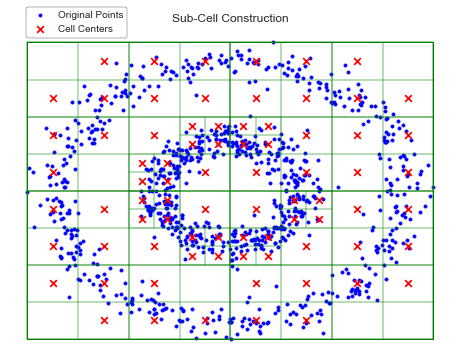

In [161]:
S_circles = coreset_construction(circles, circles_labels, k, d, eps, len(circles));

# K medians for circles

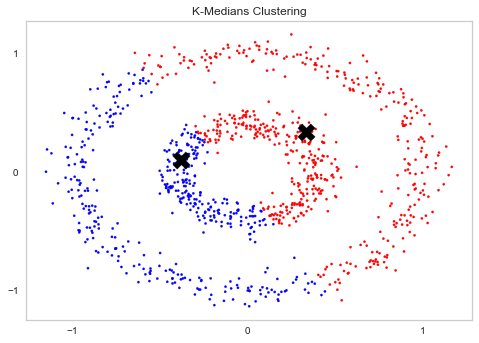

In [162]:
circles_kmedians_instance, circles_y_kmedians, circles_centers = plot_kmedians_clusters(circles, k, 5, x_ticks=[-1,0,1], y_ticks=[-1,0,1])

In [163]:
silhouette_score = metrics.silhouette_score(circles, circles_y_kmedians, metric='manhattan')
inertia = calculate_inertia(circles, circles_centers, circles_labels)

print(f"Silhouette Score: {silhouette_score}") #how well-separated the clusters are
print(f"Inertia: {inertia}") # how far the points within a cluster are from the center of that cluster.

Silhouette Score: 0.30776789038772573
Inertia: 784.1405440000002


# K medians for coreset of circles

In [164]:
corec_coreset_array, corec_coreset_labels = weighted_cs(np.array([item[0] for item in S_circles]).reshape(-1, 2),
                                              [item[1] for item in S_circles], [label for _, _, label in S_circles])

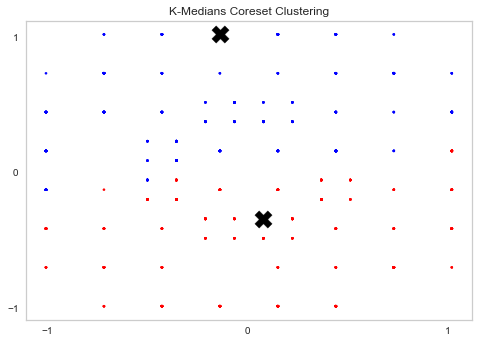

In [165]:
corec_kmedians_instance, corec_y_kmedians, corec_centers = plot_kmedians_clusters(corec_coreset_array, k, 5, 
                                                        x_ticks=[-1,0,1], y_ticks=[-1,0,1], 
                                                        title='K-Medians Coreset Clustering')

In [166]:
silhouette_score = metrics.silhouette_score(corec_coreset_array, corec_y_kmedians, metric='manhattan')
inertia = calculate_inertia(corec_coreset_array, corec_centers, corec_coreset_labels)

print(f"Silhouette Score: {silhouette_score}") #how well-separated the clusters are
print(f"Inertia: {inertia}") # how far the points within a cluster are from the center of that cluster.

Silhouette Score: 0.3324850538333424
Inertia: 1213.2897261855478


## Silhouette analysis

In [193]:
def plot_silhouette_analysis(data, clusterer, cluster_labels, n_clusters, title, ax, core_n=None):
    '''
    Adaptation of code provided in https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    '''
    ax.set_xlim([-0.2, 0.9])
    ax.set_ylim([0, len(cluster_labels) + (n_clusters + 1) * 10])

    silhouette_avg = metrics.silhouette_score(data, cluster_labels, metric='manhattan')

    sample_silhouette_values = metrics.silhouette_samples(data, cluster_labels)

    y_lower = 10
    for j in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(j) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(j))
        
        y_lower = y_upper + 10

    if core_n:    
        ax.set_title(f"{title} = {core_n}, k = {n_clusters}")
    else:
        ax.set_title(f"{title} = {data.shape[0]}, k = {n_clusters}")
    
    ax.set_xlabel("silhouette coefficient values")
    ax.set_ylabel("cluster label")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

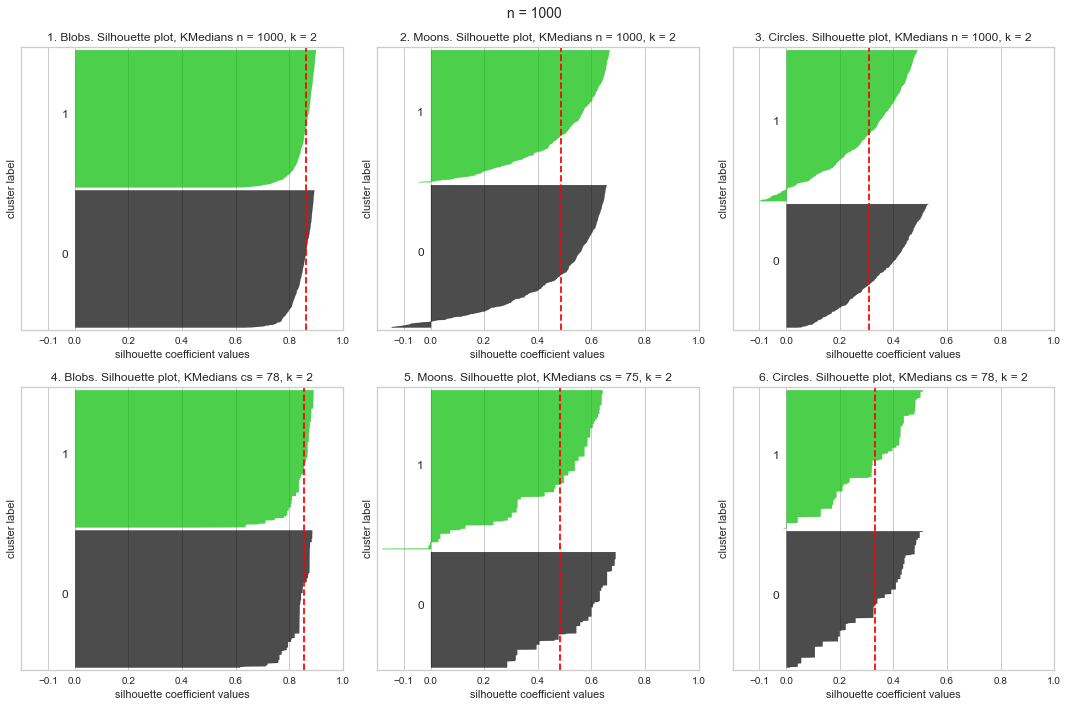

In [202]:
# Plots:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

# Original data
plot_silhouette_analysis(X, kmedians_instance, y_kmedians, k, "1. Blobs. Silhouette plot, KMedians n",  axs[0])
plot_silhouette_analysis(moons, moons_kmedians_instance, moons_y_kmedians, k, "2. Moons. Silhouette plot, KMedians n",  axs[1])
plot_silhouette_analysis(circles, circles_kmedians_instance, circles_y_kmedians, k, "3. Circles. Silhouette plot, KMedians n",  axs[2])

# Coresets
plot_silhouette_analysis(coreset_array, coreb_kmedians_instance, coreb_y_kmedians, k, "4. Blobs. Silhouette plot, KMedians cs",  axs[3], np.array(S, dtype=object).shape[0])
plot_silhouette_analysis(corem_coreset_array, corem_kmedians_instance, corem_y_kmedians, k, "5. Moons. Silhouette plot, KMedians cs",  axs[4], np.array(S_moons, dtype=object).shape[0])
plot_silhouette_analysis(corec_coreset_array, corec_kmedians_instance, corec_y_kmedians, k, "6. Circles. Silhouette plot, KMedians cs",  axs[5], np.array(S_circles, dtype=object).shape[0])

plt.suptitle(f'n = {n}', fontsize=14)
plt.tight_layout()
plt.show()